In [2]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

weights = tf.keras.models.load_model("data/model.hdf5")

# Redefine model to deactivate last's layer sigmoid
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1)) 

# 4. Pass the imagenet weights onto the second resnet
model.set_weights(weights.get_weights())

In [3]:
from sklearn.linear_model import LinearRegression

def lime(x, f, N, variance):
    # Calculate size
    flatten_input = x.ravel()
    size = flatten_input.shape[0]
    
    # take sample from multivariate gauss 
    noise = np.random.normal(loc=0.0, scale=np.sqrt(variance), size=(N, size))
    simple_input = flatten_input + noise
    complex_input = None
    
    # Batch included
    if len(x.shape) == 4:
        complex_input = simple_input.reshape((N, x.shape[1], x.shape[2], x.shape[3]))
    elif len(x.shape == 3):
        complex_input = simple_input.reshape((N, x.shape[0], x.shape[1], x.shape[2]))
    
    # Predict sample with the complex model
    y_hat = f(complex_input).numpy().reshape(complex_input.shape[0])
    
    # Fit simple model with input x and prediction y_hat of complex model
    model = LinearRegression(fit_intercept=False)
    model.fit(simple_input, y_hat)
    
    # Return simple's model parameters
    return model.coef_

In [19]:
import matplotlib.pyplot as plt

def reconstruct(image, is_cat):
    transformed_image = image.reshape((1, 256, 256, 3)).astype(np.float32) / 255.
    
    fitted_parameters = lime(transformed_image, model, 64, 0.25).reshape((256, 256, 3))
    reconstructed = fitted_parameters.copy()
    if is_cat:
        quantile = np.quantile(fitted_parameters, [0.10])[0]
        reconstructed[reconstructed < quantile] = 255
    else:
        quantile = np.quantile(fitted_parameters, [0.90])[0]
        reconstructed[reconstructed > quantile] = 255
    reconstructed = reconstructed.max(axis=2).astype(np.int32)
    return np.stack((reconstructed,)*3, axis=-1)

cat = cv2.cvtColor(cv2.resize(cv2.imread("data/cat.jpg"), (256, 256)), cv2.COLOR_BGR2RGB)
dog = cv2.cvtColor(cv2.resize(cv2.imread("data/dog.jpg"), (256, 256)), cv2.COLOR_BGR2RGB)

reconstructed_dog = reconstruct(dog, True)
reconstructed_cat = reconstruct(cat, True)

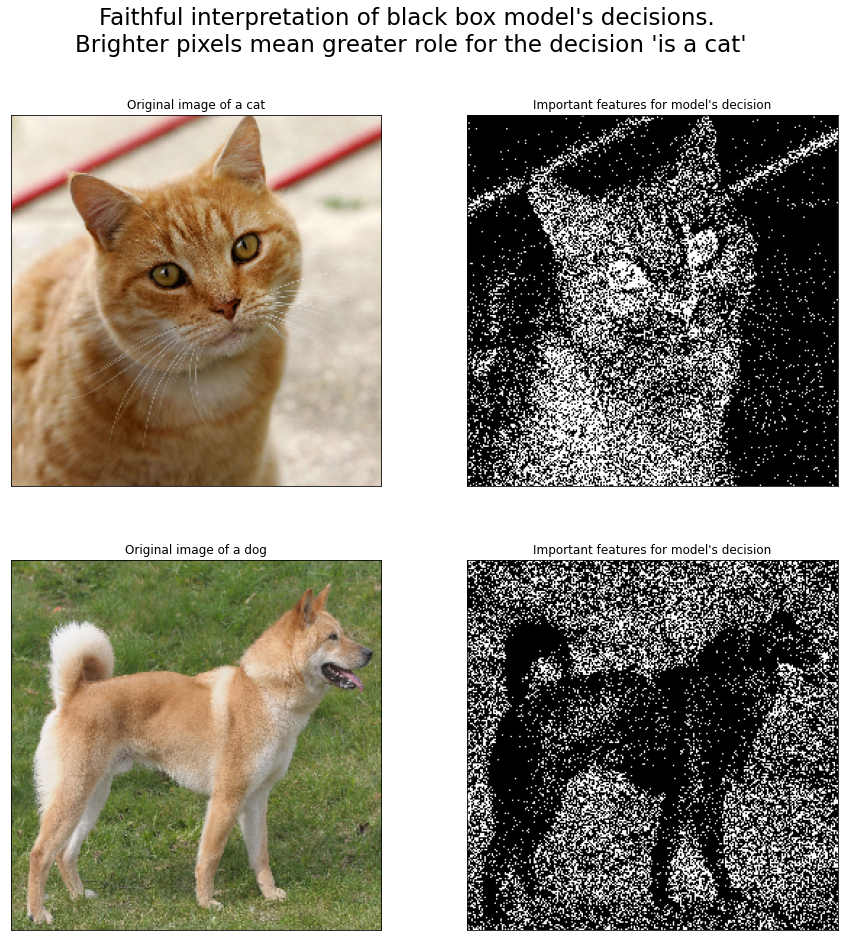

In [20]:
f, axarr = plt.subplots(2,2,figsize=(15,15))
axarr[0,0].imshow(cat)
axarr[0,1].imshow(reconstructed_cat)
axarr[1,0].imshow(dog)
axarr[1,1].imshow(reconstructed_dog)

axarr[0, 0].set_xticks([])
axarr[0, 1].set_xticks([])
axarr[1, 0].set_xticks([])
axarr[1, 1].set_xticks([])

axarr[0, 0].set_yticks([])
axarr[0, 1].set_yticks([])
axarr[1, 0].set_yticks([])
axarr[1, 1].set_yticks([])

axarr[0, 0].title.set_text("Original image of a cat")
axarr[0, 1].title.set_text("Important features for model's decision")
axarr[1, 0].title.set_text("Original image of a dog")
axarr[1, 1].title.set_text("Important features for model's decision")
f.suptitle("Faithful interpretation of black box model's decisions. \nBrighter pixels mean greater role for the decision 'is a cat'", fontsize=23)
plt.rcParams['axes.facecolor'] = 'red'
plt.rcParams['savefig.facecolor'] = 'white'
plt.savefig("output.png")
plt.show()